<h1>Предсказание успешности проектов, собирающих средства на Kickstarter при помощи моделей МО</h1>
<h2>Описание задачи</h2>

<p>Выбранный набор данных представляет из себя статистику всех краудфандинговых кампаний, которые были запущены на платформе Kickstarter с 2009 по 2018 годы. Он включает в себя информацию о проектах, таких как название, категория, дата запуска и дедлайн, сумма, которую он собрал, сумма, которую планировалось собрать и прочие метрики. 

На основании этих данных можно обучить разные модели, которые смогут предсказывать успешность проекта на основе параметров его кампании на Kickstarter. В качестве меры успешности кампании будет выступать поле "state" со следующими значениями:</p>

In [ ]:
import pandas as pd 
df = pd.read_csv('dataset.csv')
print(df['state'].unique())

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']


<p>Состояния live и undefined нам особо не интересны; suspended, canceled и failed свидетельствуют о провале кампании. Значит, при обучении модели успешными стоит считать только записи со статусом successful. Таким образом, приняв state = 'successful' за 1, а все остальные значения за 0, мы можем свести задачу предсказания успешности кампании к классической задаче классификации, которую можно решить методом логистической регрессии.</p>

<h2>Анализ, первичная чистка и обработка данных</h2>
<p>Датасет содержит большое количество данных, не все из которых имеют значение в рамках поставленной задачи. 
Выведем некоторую базовую информацию о наборе данных в исходном состоянии</p>

In [ ]:

import pandas as pd 

df = pd.read_csv('dataset.csv')

print("Data Information :\n ")
print(df.info())

print("Number of nulls for column : \n")
print(df.isnull().sum())

print("Data statistics : \n")
print(df.describe())


Data Information :
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage

Из вывода видно, что в таблице аж 378 тысяч строк и почти нет пустых (null) значений. Это позволяет отбросить null-значения и всё равно оставить более чем достаточное количество данных для обучения и тестирования моделей.
Так же статистика показывает, что среднее значение (mean) поля usd_pledged_real (кол-во инвестированных денег в переводе в доллары США) заметно меньше значения usd_goal_real (цель кампании по сбору денег в долларах США). Из этого можно сделать вывод, что в среднем краудфандинговые кампании не достигают поставленных целей и стоит ожидать больше отрицательных результатов, чем положительных.

Рассматривая столбцы по отдельности можно выделить заведомо не имеющие значения для нас столбцы, а также сделать предположения о важности тех или иных признаков, которые мы эмпирически проверим позже. Так, например, столбец ID очевидно не несёт полезной информации, usd_pledged отличается от usd_pledged_real лишь инструментом конвертации суммы в USD и по своему смыслу полностью дублирует его, а goal и pledged не только дублируются, но и вообще выражены в изначальной валюте сбора и, соответственно, не нормализованы относительно строк с другими показателями валюты. Столбцы currency (валюта) и country (страна) вероятно также не имеют особого значения, но они всё же несут уникальную информацию, релевантность которой стоит проверить.

Смотря от обратного, можно заметить, что name, category и main_category можно использовать для категоризации, backers (кол-во поддержавших), usd_goal_real, usd_pledged_real имеют непосредственное отношение к финансовому аспекту, а launched и deadline - к сроку кампании. Исходя из этого можно предположить, что значения в этих столбцах будут иметь значение для прогнозирования успеха кампании.

Тем не менее, для более удобного взаимодействия с этими данными их стоит обработать. А именно:
-Конвертировать строковые значения статуса (state) в булевы значения успешности (success)
-Конвертировать даты в формат datetime, чтобы с ними можно было действительно работать как с датами при помощи pandas
-Объединить launched и deadline в одно поле, указывающее на продолжительность кампании в одном значении
-Создать дополнительные признаки, касающиеся времени старта кампании


In [ ]:
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    """
    Предобработка данных Kickstarter
    """
    # Создаем копию данных
    data = df.copy()
    
    # Создаем целевую переменную (1 - успешная, 0 - неуспешная)
    data['success'] = (data['state'] == 'successful').astype(int)
    
    # Удаляем строки с отсутствующими значениями в ключевых столбцах
    data = data.dropna(subset=['usd_goal_real', 'usd_pledged_real', 'backers'])
    
    # Обработка дат
    data['launched'] = pd.to_datetime(data['launched'])
    data['deadline'] = pd.to_datetime(data['deadline'])
    data['campaign_duration'] = (data['deadline'] - data['launched']).dt.days
    
    # Создание дополнительных признаков
    data['launch_year'] = data['launched'].dt.year
    data['launch_month'] = data['launched'].dt.month
    data['launch_day_of_week'] = data['launched'].dt.dayofweek

    #--------------------------------------------------
    # Здесь будет подготовка данных к обучению модели
    #--------------------------------------------------

    return data

<h2>Обучение модели логистической регрессии</h2>

Чтобы дальнейший анализ не был безосновательным, надо на имеющихся данных обучить модель и посмотреть на результаты её работы.

Для этого сначала закончим подготовку данных для передачи в модель, дописав функцию preprocess_data:

In [ ]:
def preprocess_data(df):

    #---------------------------------------------
    # Код из предыдущего сегмента
    #---------------------------------------------

    # Категориальные переменные
    label_encoders = {}
    categorical_columns = ['category', 'main_category', 'currency', 'country']
    
    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le
    
    # Выбираем признаки для модели
    feature_columns = [
        'usd_goal_real', 'backers', 'campaign_duration',
        'launch_year', 'launch_month', 'launch_day_of_week'
    ]
    
    # Добавляем закодированные категориальные признаки
    for col in categorical_columns:
        if col + '_encoded' in data.columns:
            feature_columns.append(col + '_encoded')
    
    # Удаляем выбросы (используем IQR метод для числовых столбцов)
    numeric_features = ['usd_goal_real', 'backers', 'campaign_duration']
    for col in numeric_features:
        if col in data.columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    
    return data, feature_columns, label_encoders

Теперь можно приступить к созданию самой модели. Благодаря отличной библиотеке Scikit-learn для Python сделать это не очень сложно, достаточно правильно указать все параметры.

Функция, создающая модель и обучающая её на месте, получилась вот такой:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def train_model(data, feature_columns):
    """
    Обучение модели логистической регрессии
    """
    # Подготовка данных
    X = data[feature_columns]
    y = data['success']
    
    # Разделение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Масштабирование признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Обучение модели
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    return model, scaler, X_train_scaled, X_test_scaled, y_train, y_test, y_pred, y_pred_proba

<h2>Анализ результатов и характеристик данных</h2>

Теперь, когда у нас есть модель, мы можем оценить влияние тех или иных признаков. Для этого соберём данные и с помощью библиотеки matplotlib построим графики, которые позволят визуализировать результаты для последующего анализа.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np

def analyze_feature_importance(model, feature_columns, X_train_scaled, y_train):
    """
    Анализ важности признаков
    """
    # Коэффициенты логистической регрессии
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\n=== ВАЖНОСТЬ ПРИЗНАКОВ ===")
    print(feature_importance)
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['abs_coefficient'])
    plt.xlabel('Абсолютное значение коэффициента')
    plt.title('Важность признаков (абсолютные значения коэффициентов)')
    plt.tight_layout()
    plt.show()
    
    # Статистический анализ признаков
    selector = SelectKBest(score_func=f_classif, k='all')
    X_selected = selector.fit_transform(X_train_scaled, y_train)
    
    feature_scores = pd.DataFrame({
        'feature': feature_columns,
        'f_score': selector.scores_,
        'p_value': selector.pvalues_
    }).sort_values('f_score', ascending=False)
    
    print("\n=== F-СТАТИСТИКА ПРИЗНАКОВ ===")
    print(feature_scores)
    
    return feature_importance, feature_scores


Полученный график:

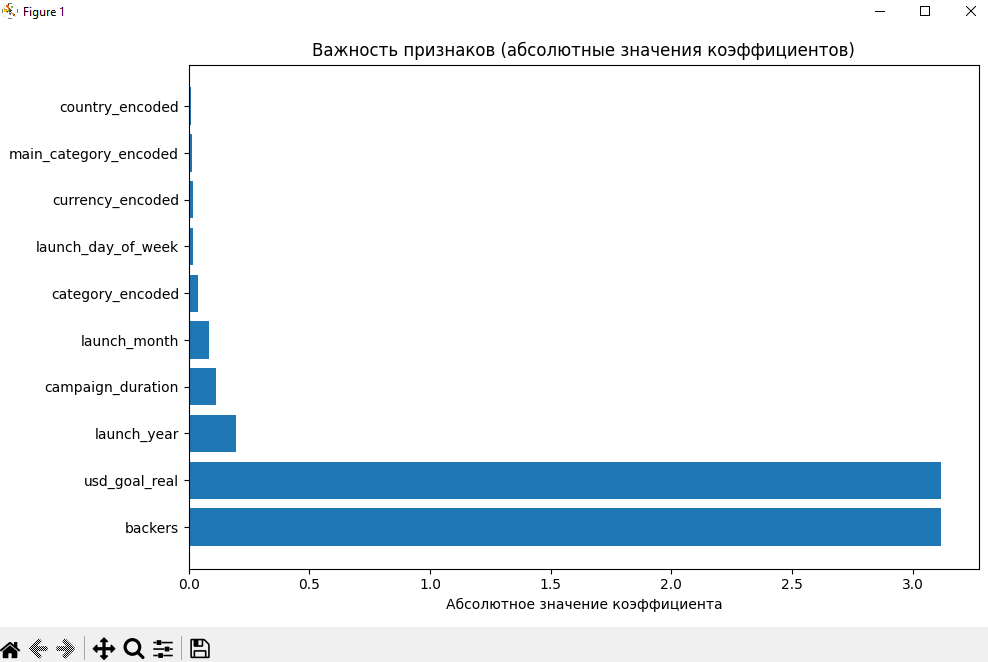

Как мы можем заметить, самыми значительными для модели параметрами оказались backers и usd_goal_real. Некоторую значимость показывают launch_year, launch_month и campaign_duration. Все остальные показатели (в том числе, как и предполагалось, currency и country) оказались максимально незначительными и почти не влияют на результат.

Связать это можно с тем, что backers показывает количество человек, уже поддержавших проект, тем самым напрямую приблизив его к достижению цели. Usd_goal_real также является одним из самых существенных показателей, т.к. реалистичные и достижимые цели краудфандинга крепко связаны с его успехом.

Интересным является важность признака launch_year. Такой результат может свидетельствовать о неравномерном распределении успешных проектов с течением времени.



Помимо важности признаков стоит рассмотреть их корреляцию, что можно сделать с помощью матрицы корреляций.

In [ ]:
import seaborn as sns

def correlation_analysis(data, feature_columns):
    """
    Анализ корреляций между признаками
    """
    correlation_matrix = data[feature_columns + ['success']].corr()
    
    print("\n=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ===")
    print("Корреляция признаков с целевой переменной:")
    target_corr = correlation_matrix['success'].sort_values(ascending=False)
    print(target_corr)
    
    # Тепловая карта корреляций
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f')
    plt.title('Матрица корреляций')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

Результат:

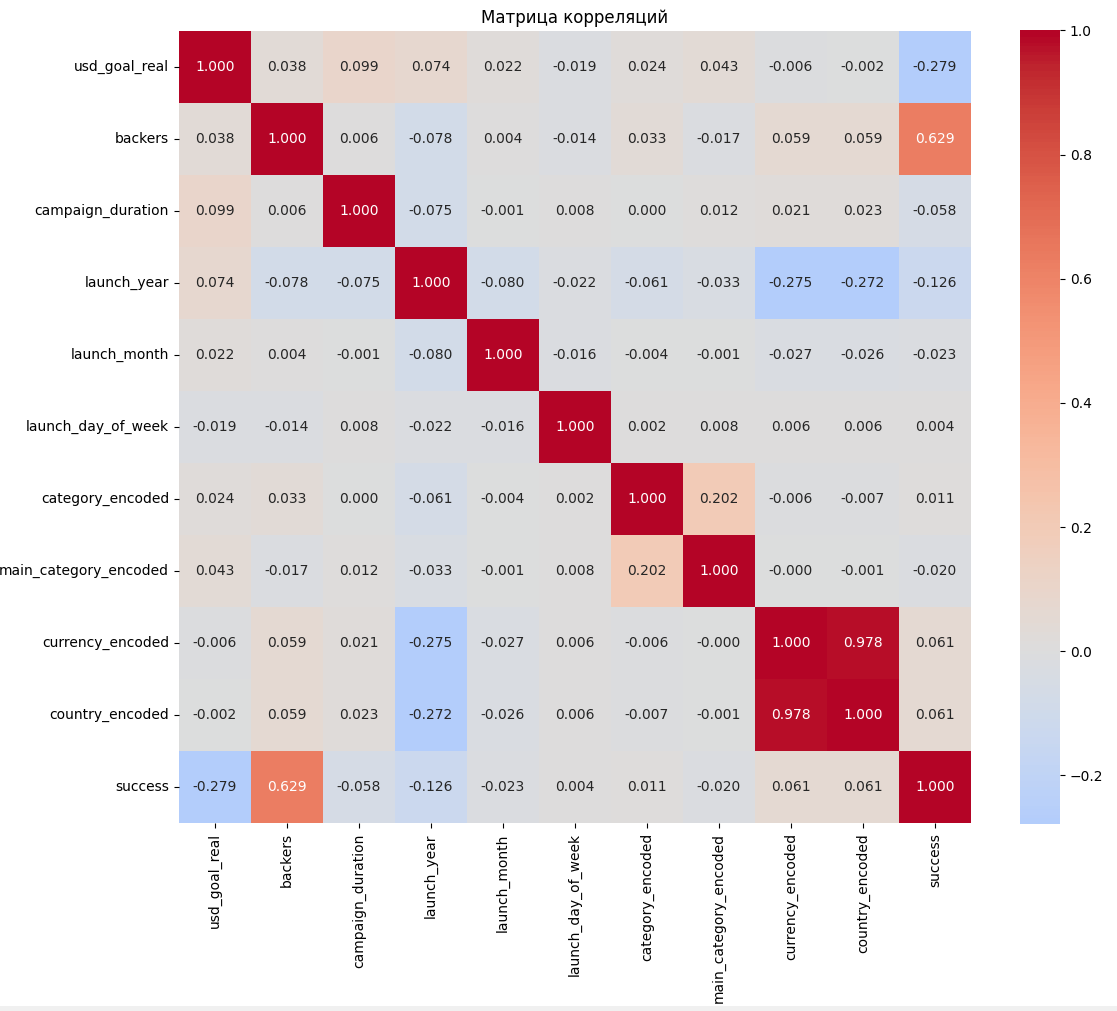

В матрице корреляций, выполненной в виде тепловой карты можно заметить несколько аномалий, а именно: currency_encoded и country encoded имеют очень высокую степень корреляции, то есть какое-то конкретное значение в одном из полей почти гарантированно свидетельствует об ином конкретном значении в другом. Для нас это значит, что эти два столбца несут в себе практически одинаковую информацию и один из них можно беспрепятственно удалить; backers имеет необычайно высокий показатель корреляции с success, что свидетельствует о том, что количество спонсоров напрямую влияет на успех проекта.

<h2>Анализ точности модели</h2>

Помимо проверки изначального анализа на эффективность параметров, следует так же проверить саму модель на точность различными методами, например встроенными в модуль sklearn.

In [5]:
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve)

def evaluate_model(y_test, y_pred, y_pred_proba):
    """
    Оценка качества модели
    """
    # Основные метрики
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===")
    print(f"Точность (Accuracy): {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nДетальный отчет по классификации:")
    print(classification_report(y_test, y_pred))
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Неуспешная', 'Успешная'],
                yticklabels=['Неуспешная', 'Успешная'])
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()
    
    return accuracy, roc_auc

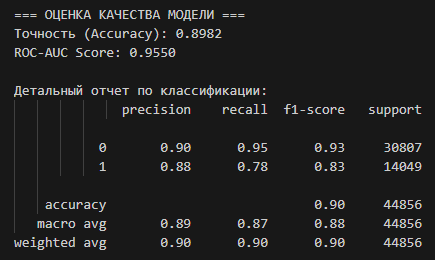

Точность модели в её нынешней конфигурации оказалась довольно неплохой - почти 0.90
Возможно это связано с высокой корреляцией между backers и success, которая позволяет сопоставить этот параметр с размером целевой суммы и в результате довольно точно определить вероятность успеха кампании.

Также для анализа точности пригодится матрица ошибок

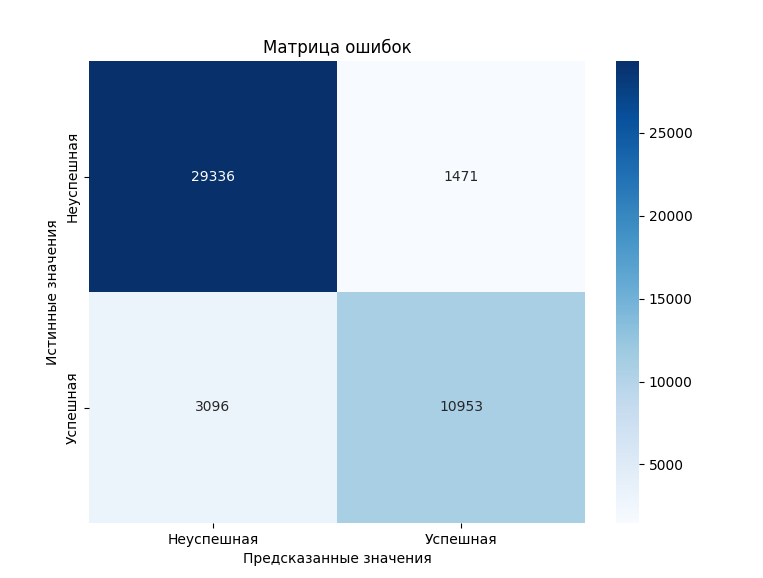

По ней можно заметить, что количество правильных прогнозов сильно превышает кол-во неправильных. Что интересно, хоть, как и ожидалось, большинству кампаний не удалось собрать необходимое количество средств, количество FN (False Negative - модель предсказала неудачу и ошиблась) заметно превышает количество FP (False Positive - модель предсказала успех и ошиблась).

<h2>Вывод</h2>

Несмотря на то, что при изначальном анализе данных были допущены неточности, модель показала высокий уровень точности и надёжности. Перспективы развития довольно обширны: следует более тщательно очистить параметры, в частности следует уделить особое внимание поведению параметра backers, т.к. несмотря на его высокую корреляцию с успехом он будет недоступен для планирующихся или только начавшихся краудфандинговых кампаний. 

<h2>Дерево решений</h2>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def train_decision_tree(data, feature_columns):
    # Подготовка данных
    X = data[feature_columns]
    y = data['success']
    
    # Разделение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Подбор гиперпараметров для дерева решений
    dt_params = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring='roc_auc', n_jobs=-1)
    dt_grid.fit(X_train, y_train)  # Деревья не требуют масштабирования
    
    dt_best = dt_grid.best_estimator_
    dt_pred = dt_best.predict(X_test)
    dt_pred_proba = dt_best.predict_proba(X_test)[:, 1]

    return dt_model, scaler, X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test

<h2>Нейронная сеть (MLP)</h2>

In [ ]:
from sklearn.neural_network import MLPClassifier

def train_neural_network(data, feature_columns):
    # Подготовка данных
    X = data[feature_columns]
    y = data['success']
    
    # Разделение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Масштабирование признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Подбор гиперпараметров для нейронной сети
    nn_params = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    nn_model = MLPClassifier(random_state=42, max_iter=500)
    nn_grid = GridSearchCV(nn_model, nn_params, cv=5, scoring='roc_auc', n_jobs=-1)
    nn_grid.fit(X_train_scaled, y_train)
    
    nn_best = nn_grid.best_estimator_
    nn_pred = nn_best.predict(X_test_scaled)
    nn_pred_proba = nn_best.predict_proba(X_test_scaled)[:, 1]

    return nn_model, scaler, X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test

Расписать про эти модели не успел, к сожалению
